In [87]:
# Chord Identification: Prototype Demo

# -- Import libraries --

import numpy as np
from numpy.fft import fft, ifft
import math
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.signal import find_peaks
from IPython.display import Audio
from IPython.display import display

# -- Function definitions --

def apply_fft(data, Fs):
    N = len(data)
    fft_result = fft(data)
    freq = np.fft.fftfreq(N, 1/Fs)
    pos_freq = freq[:N//2]
    mag = 2*np.abs(fft_result[:N//2])
    # plt.figure(figsize=(12, 6))
    # plt.plot(pos_freq,mag)
    # plt.title("Original Frequency Spectrum")
    # plt.xlabel("Frequency (Hz)")
    # plt.ylabel("Amplitude")
    # plt.show()
    
    return fft_result, pos_freq, mag

def denoising_Rayleigh(fft_result, Fs):
    N = len(fft_result)
    mag = np.abs(fft_result)
    # Median Absolute Deviation
    median = np.median(mag)
    mad = np.median(np.abs(mag-median))
    
    # Rayleigh Distribution
    b_hat = 2.2299*mad
    threshold = np.sqrt(2*b_hat**2 * np.log(N))
    
    #numpy.where(condition, [x, y, ]/)
    denoised_fft = np.where(mag>threshold, fft_result*(1-threshold/mag),0) #soft thresholding
    
    # Plot
    # plt.figure(figsize=(12, 6))
    # freq = np.fft.fftfreq(N, 1/Fs)
    # pos_freq = freq[:N//2]
    # denoised_fft_spec = np.abs(denoised_fft[:N//2])
    # plt.xlabel("Frequency (Hz)")
    # plt.ylabel("Amplitude")
    # plt.title("Denoised Frequency Spectrum")
    # plt.plot(pos_freq, denoised_fft_spec)
    # plt.show()
    
    # Rescaling
    denoised_audio=np.real(ifft(denoised_fft))
    denoised_audio=np.int16(denoised_audio/np.max(np.abs(denoised_audio))*32767) 
    
    return denoised_fft, denoised_audio

def denoising_manual(fft_result, Fs):
    N = len(fft_result)
    threshold = np.max(np.abs(fft_result)) * 0.1  
    denoised_fft = np.where(np.abs(fft_result)>threshold, fft_result, 0)
    plt.figure(figsize=(12, 6))
    freq = np.fft.fftfreq(N, 1/Fs)
    pos_freq = freq[:N//2]
    denoised_fft_spec = np.abs(denoised_fft[:N//2])  
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Chord DFT (Saw)")
    plt.plot(pos_freq, denoised_fft_spec) 
    plt.show()
    # Rescaling 
    denoised_audio=np.real(ifft(denoised_fft))
    denoised_audio=np.int16(denoised_audio / np.max(np.abs(denoised_audio)) * 32767) 
    return denoised_fft, denoised_audio

def find_peak_frequencies(pos_freq, mag):
    # Find peaks
    peaks, _ = find_peaks(mag, height=np.max(mag)/10) #Modify divisor 
    peak_mag = mag[peaks]
    top_3_indices = np.argsort(peak_mag)[-3:][::-1] #indices of 3 largest value. Used online source as reference
    top_3_peaks = peaks[top_3_indices]
    top_freq = pos_freq[top_3_peaks]
    top_mag = mag[top_3_peaks]
    
    # Plot
    # plt.figure(figsize=(12, 6))
    # plt.plot(pos_freq, mag)
    # plt.plot(top_freq, top_mag,'ro')
    # plt.title("Frequency Spectrum with Peak Frequencies")
    # plt.xlabel("Frequency (Hz)")
    # plt.ylabel("Amplitude")
    # plt.show()
    # Print peak frequencies
    # print("Peak 3 frequencies:")
    # for i, freq in enumerate(top_freq):
    #     print(f"Peak {i+1}: {abs(freq): } Hz ")
    # return top_freq, top_mag

# def generate_audio1(filename):
#     Fs, data = read(filename)
#     fft_result, pos_freq, mag = apply_fft(data, Fs)
#     denoised_fft, denoised_audio = denoising_Rayleigh(fft_result, Fs)
#     denoised_magnitude = np.abs(denoised_fft[:len(pos_freq)])
#     top_3_frequencies, top_3_magnitudes = find_peak_frequencies(pos_freq, denoised_magnitude)
#     output_filename = 'denoised_' + filename
#     write(output_filename, Fs, denoised_audio)
#     return Audio(denoised_audio, rate=Fs)

# def generate_audio2(filename):
#     Fs, data = read(filename)
#     fft_result, pos_freq, mag = apply_fft(data, Fs)
#     denoised_fft, denoised_audio = denoising_manual(fft_result, Fs)
#     denoised_magnitude = np.abs(denoised_fft[:len(pos_freq)])
#     top_3_frequencies, top_3_magnitudes = find_peak_frequencies(pos_freq, denoised_magnitude)
#     output_filename = 'denoised_ver_2' + filename
#     write(output_filename, Fs, denoised_audio)
#     return Audio(denoised_audio, rate=Fs)

# -- Main --

Fs, data = read('A_major_noise.wav')
Audio(data, rate=Fs)

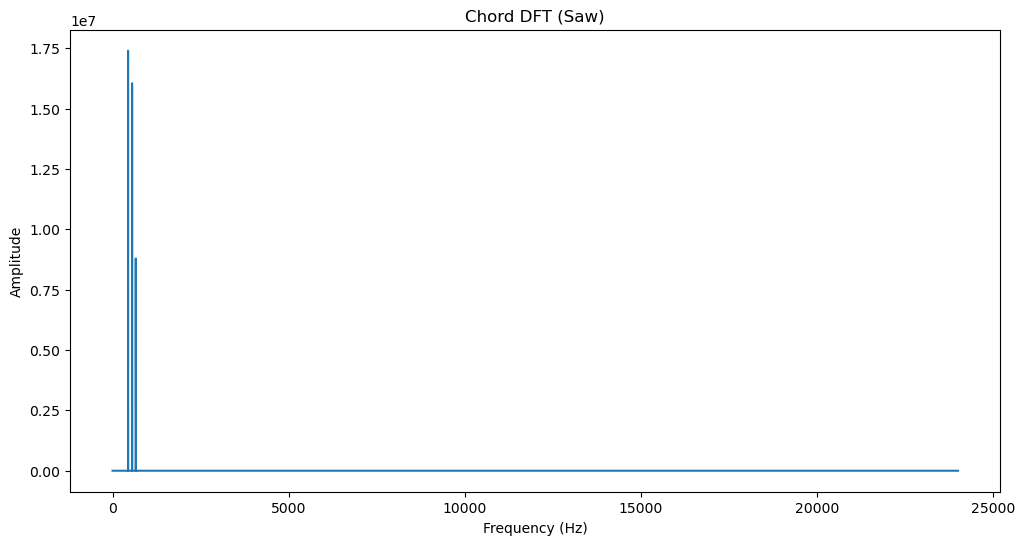

Improved Pitch Class Profile:
[ 0.         88.17133105  0.          0.         83.82197786  0.
  0.          0.          0.         75.39669245  0.          0.        ]


Notes present: A, E, C#/Db


Chord identified: A Major


In [88]:
# Get denoised amplitude spectrum
fft_result, pos_freq, mag = apply_fft(data, Fs)
denoised_fft, denoised_audio = denoising_manual(fft_result, Fs)
denoised_magnitude = np.abs(denoised_fft[:len(pos_freq)])

# # Given a denoised amplitude spectrum
size = pos_freq.shape[0]
spec_new = np.zeros(size)

# Multiply downsampled copies (M=4) to obtain HPS
for k in range(size):
    prod = denoised_magnitude[k]
    if (2*k < size) and (denoised_magnitude[2*k] > 0):
        prod *= denoised_magnitude[2*k]
    if (4*k < size) and (denoised_magnitude[4*k] > 0):
        prod *= denoised_magnitude[4*k]
    if (8*k < size) and (denoised_magnitude[8*k] > 0):
        prod *= denoised_magnitude[8*k]
    spec_new[k] = np.sqrt(np.sqrt(prod))
    
# Calculate IPCP

f_ref = 130.81278265   # Define middle C (C3) as our reference freq.
ipcp = np.zeros(12)

for k in range(1, size):
    # Find p(k)
    p_k = np.round(12*math.log2((k/float(size))*(Fs/float(f_ref)))) % 12
    # Add squared amplitude to corresponding bin
    ipcp[int(p_k)] += spec_new[k]**2

# Square root, then normalize
ipcp = np.sqrt(ipcp)
Z = np.max(ipcp)
print("Improved Pitch Class Profile:")
print(ipcp)
print("\n")
ipcp = ipcp / float(Z)

notes = ind = np.argpartition(ipcp, -3)[-3:]

scores = np.empty(3) #Holds the score each frequency gets if assumed to be the root note

        #                   C     D     E  F     G     A      B
Interval_Points = np.array([0, 0, 3, 5, 5, 3, 0, 7, 0, 1, 2,  1])   #Holds a score for any given interval. Can be tweaked as wanted        
        #                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]) 
        #                         2  m3 M3 4     5     6  b7  M7

Chord_Names = [['C Major', 'C#/Db Major', 'D Major' , 'D#/Eb Major', 'E Major', 'F Major', 'F#/Gb Major', 'G Major', 'G#/Ab Major', 'A Major', 'A#/Bb Major', 'B Major'],
               ['C Minor', 'C#/Db Minor', 'D Minor' , 'D#/Eb Minor', 'E Minor', 'F Minor', 'F#/Gb Minor', 'G Minor', 'G#/Ab Minor', 'A Minor', 'A#/Bb Minor', 'B Minor']]

Note_Names = ['C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab', 'A', 'A#/Bb', 'B']

print("Notes present: " + Note_Names[int(notes[0])] + ", " + Note_Names[int(notes[1])] + ", " + Note_Names[int(notes[2])])
print("\n")

#Try each note as root note, determine a likelihood score for that configuration
for i in range (0, 3):
    d1 = int(notes[(i+1)%3] - notes[i%3]) #find interval distance 1
    d2 = int(notes[(i+2)%3] - notes[i%3]) #find interval distance 2
    if (d1 < 0):  #correct d1 interval for direction
        d1 = d1 + 12
    if (d2 < 0):  #correct d2 interval for direction
        d2 = d2 + 12       
    scores[i] = Interval_Points[d1] + Interval_Points[d2] 

#determine which root note got highest likelihood score
max_score = 0
max_score_idx = 0
for i in range (0, 3):
    if (scores[i] > max_score):
        max_score_idx = i
        max_score = scores[i]
        
#re-calculate intervals for the winning root noot
d1 = int(notes[(max_score_idx+1)%3] - notes[max_score_idx%3]) #find interval distance 1
d2 = int(notes[(max_score_idx+2)%3] - notes[max_score_idx%3]) #find interval distance 2 
if (d1 < 0):  #correct d1 interval for direction
        d1 = d1 + 12
if (d2 < 0):  #correct d2 interval for direction
        d2 = d2 + 12

#check if major or minor, and select chord name
if (d1 == 3 or d2 == 3):
    print("Chord identified: " + (Chord_Names[1][int(notes[max_score_idx])])) # if a minor third is present, select minor chord
else:
    print("Chord identified: " + (Chord_Names[0][int(notes[max_score_idx])])) # else select major chord
